# DMFT calculation with IPT
Author: [Fumiya KAKIZAWA](mailto:f.kakizawa.178@ms.saitama-u.ac.jp), [Rihito SAKURAI](mailto:sakurairihito@gmail.com), [Hiroshi SHINAOKA](mailto:h.shinaoka@gmail.com)

## Theory

### Self-consistent equation
We will solve the Hubbard model using the dynamical mean-field theory (DMFT) [1].
We compute a paramagnetic soluation assuming the non-interacting semi-circular density of state

$$
    \rho(\omega) = \frac{\sqrt{4-\omega^2}}{2\pi},
$$

at half filling.

The self-consistent equations to be solved are

$$
    G_{\mathrm{loc}}(\mathrm{i}\omega_n) = \int d\omega \frac{\rho(\omega)}{\mathrm{i}\omega_n-\omega+\mu-\Sigma(\mathrm{i}\omega_n)}, 
$$

$$
    \mathcal{G}^{-1}(\mathrm{i}\omega_n) = G_{\mathrm{loc}}^{-1}(\mathrm{i}\omega_n) + \Sigma(\mathrm{i}\omega_n),
$$

$$
    \Sigma(\tau) = U^2\mathcal{G}^2(\tau)\mathcal{G}(\beta-\tau),
$$

where 
$G_{\mathrm{loc}}$ is the local Green function, 
$\omega_n$ is a fermionic Matsubara frequency, 
$\mu$ is the chemical potential ($\mu=U/2$ at half filling),
$U$ is the onsite-Coulomb interaction,
$\Sigma$ is the self-energy,
$\mathcal{G}$ is the cavity Green function defined as
$$
\mathcal{G}(\mathrm{i}\omega_n) = \frac{1}{\mathrm{i}\omega_n - \mu - \Delta(\mathrm{i}\omega_n)},
$$
$\Delta$ is the hybrization function,
$\tau$ is the imaginary time, $\beta$ is the inverse temperature.
Here, we compute the self-energy within the interative perturbation theory (IPT) [1].

### Renormalization factors

The Mott transition can be detected by monitoring the renormalization factor
$$
z = \frac{1}{1-\frac{\partial \Sigma(\omega+\mathrm{i}0^+)}{\partial \omega}}\Big|_{\omega=0} \approx \frac{1}{1 - \frac{\Sigma(\mathrm{i}\omega_1)-\Sigma(\mathrm{i}\omega_0)}{\mathrm{i}\omega_1 - \mathrm{i}\omega_0 }}.
$$

In the non-interacting limit $U\rightarrow 0$, we have $z\rightarrow 1$. Correlation effects reduce $z$ as $z < 1$.

[1] A. Georges and G. Kotliar, Phys. Rev. B 45, 6479 (1992)

## Implmementation

In [10]:
using OMEinsum
using FastGaussQuadrature
using SparseIR
using LaTeXStrings
using Plots
using LinearAlgebra

### Non-interacting DOS

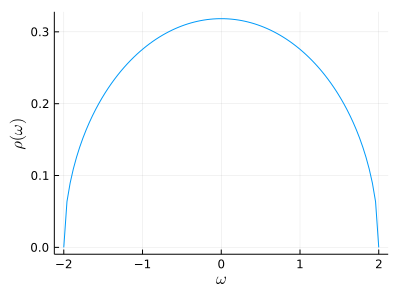

In [11]:
"""
Compute spectral function rho(omega)
"""
rho_omega(omega::Float64) = sqrt(4 - omega^2) / (2*pi)

num_omega = 100
omegas = collect(range(-2, 2, length=num_omega))
rho = rho_omega.(omegas)
p = plot(xlabel="\$\\omega\$", ylabel = "\$\\rho(\\omega)\$", size=(400,300))
plot!(omegas, rho, label=nothing)

### Self-consistent equation

In [12]:
"""
Gauss-Legendre quadrature rule of degree `deg` for the interval [xmin, xmax]
"""
function _gausslegendre(deg::Int, xmin::Float64, xmax::Float64)
    @assert xmin < xmax
    x, w = gausslegendre(deg)
    dx = xmax - xmin
    w_ = 0.5 * dx * w
    x_ = (0.5 * dx) * (x .+ 1) .+ xmin
    return x_, w_
end
;

In [16]:
"""
Solver
"""
struct IPTSolver
    U::Float64
    basis::FiniteTempBasis{LogisticKernel, Float64}
    beta::Float64
    rho_omega::Function
    omega_range::Tuple{Float64,Float64}
    quad_rule::Tuple{Vector{Float64}, Vector{Float64}}
    smpl_matsu::MatsubaraSampling{Int64, FiniteTempBasis{LogisticKernel, Float64}, ComplexF64, Float64}
    smpl_tau::TauSampling{Float64, FiniteTempBasis{LogisticKernel, Float64}, Float64, Float64}

    function IPTSolver(U::Float64, basis, rho::Function,
        omega_range::Tuple{Float64,Float64}, deg_leggaus::Int64=100)

        quad_rule = _gausslegendre(deg_leggaus, omega_range...)
        smpl_matsu = MatsubaraSampling(basis)
        smpl_tau = TauSampling(basis)

        new(U, basis, SparseIR.getbeta(basis), rho_omega, omega_range, quad_rule, smpl_matsu, smpl_tau)
    end
end
;

LoadError: TypeError: in Type, in F, expected F<:SVD, got Type{ComplexF64}

In [ ]:
""" Solve Dyason equation: Compute G_loc(iv) from Sigma_iv """
function compute_gloc_iv(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}})
    iv = 1im .* solver.smpl_matsu.sampling_points .* π / solver.beta
    newaxis = [CartesianIndex()]
    gloc_iv = ein"q,q,wq->w"(
            solver.quad_rule[2],
            solver.rho_omega.(solver.quad_rule[1]),
            1 ./ ((iv .- sigma_iv)[:, newaxis] .- solver.quad_rule[1][newaxis, :])
        )
    return gloc_iv
end

""" Compute IPT Sigma(iv) from mathcal{G}(iv)"""
function compute_sigma_iv(solver::IPTSolver, g0_iv::Vector{ComplexF64})
    g0_IR = fit(solver.smpl_matsu, g0_iv, dim=1)
    g0_tau = evaluate(solver.smpl_tau, g0_IR)
    #sigma_tau = (solver.U)^2 .* (g0_tau).^2 .* g0_tau[end:-1:1]
    sigma_tau = (solver.U)^2 .* (g0_tau).^3
    sigma_IR = fit(solver.smpl_tau, sigma_tau)
    return evaluate(solver.smpl_matsu, sigma_IR, dim=1)
end

""" Perform one self-consistent loop """
function onestep(solver::IPTSolver, sigma_iv::Vector{Complex{Float64}},is_rmp)
    gloc_iv = compute_gloc_iv(solver, sigma_iv)

    if is_rmp == true
        iv = im * solver.smpl_matsu.sampling_points .* pi/solver.beta
        g0_iv = 1 ./ (iv .- gloc_iv)
    else 
        g0_iv = 1 ./ ((1 ./ gloc_iv) .+ sigma_iv)
    end

    return compute_sigma_iv(solver, im .* imag.(g0_iv))
end
;

### Computation of renormalization factors

In [ ]:
function renormalization_factor(solver::IPTSolver, sigma_iv0::Union{Nothing,Vector{ComplexF64}}, nitr::Int, mixing::Float64,is_rmp)
    # Initialize sigma_iv
    if isnothing(sigma_iv0)
        sigma_iv = zeros(ComplexF64,length(solver.smpl_matsu.sampling_points))
    else
        sigma_iv = copy(sigma_iv0)
    end

    # mixing sigma_iv with new_sigma_iv
    for i in 1:nitr
        new_sigma_iv = onestep(solver,sigma_iv,is_rmp)
        rdiff = sum(abs.(new_sigma_iv .- sigma_iv)) / sum(abs.(new_sigma_iv))
        if rdiff < 1e-14
            break
        end
        sigma_iv = mixing .* new_sigma_iv .+ (1-mixing) .* sigma_iv
    end

    center = Int(length(sigma_iv)/2) + 1 # julia 
    delta_sigma_iv = sigma_iv[center+1]-sigma_iv[center]
    inv_z = (1 - imag(delta_sigma_iv)*solver.beta/(2*pi))

    return 1/inv_z, sigma_iv
end
;


In [ ]:
function sweepU(basis::FiniteTempBasis{LogisticKernel, Float64}, D::Float64, U_range::Vector{Float64}, rho_omega::Function, omega_range::Tuple{Float64, Float64}, nitr::Int, mixing::Float64,is_rmp)
    Z = Float64[]
    sigma_history = []
    for iu in U_range
        solver = IPTSolver(iu, basis, rho_omega, omega_range)
        sigma_iv0 = length(sigma_history) > 0 ? sigma_history[end][1] : nothing
        z, sigma_ = renormalization_factor(solver, sigma_iv0, nitr, mixing,is_rmp)
        push!(sigma_history, (sigma_,solver.smpl_matsu.sampling_points,solver))
        if z > 0
            push!(Z, z)
        else
            push!(Z,0.0)
        end
        #if z > 0
        #    push!(Z, z)
        #else
        #    break
        #end
    end
    println("is RMP?= $(is_rmp)")

    return Z, sigma_history
end

# Setup parameters
D = 2.0
temp = 0.1 / D
beta = 1 / temp
wmax = 10.0 * D
lambda = beta * wmax
eps = 1e-15
wmax = lambda / beta
basis = FiniteTempBasis(fermion, beta, wmax, eps)

# Perform a sweep by increasing U
num_U = 50
U_min = 0.0 / D
U_max = 7.5 / D
U_range = 2 .* collect(range(U_min, U_max, num_U))
omega_range = (-2.0, 2.0)
nitr = 1000
mixing = 0.25
is_rmp = false
Z, sigma_history = sweepU(basis, D, U_range, rho_omega, omega_range, nitr, mixing,is_rmp)
is_rmp = true
Z_rmp, sigma_history_rmp = sweepU(basis, D, U_range, rho_omega, omega_range, nitr, mixing,is_rmp);

is RMP?= false
is RMP?= true


In [ ]:
idx = 30
solver = sigma_history[idx][3]
println("U = $(solver.U)")
sigma_iv  = sigma_history[idx][1]
gloc_iv = compute_gloc_iv(solver, sigma_iv)
g0_iv = im .* imag.(1 ./ ((1 ./ gloc_iv) .+ sigma_iv))
g0_IR = fit(solver.smpl_matsu, g0_iv, dim=1)
g0_tau = evaluate(solver.smpl_tau, g0_IR)
sigma_tau1 = (solver.U)^2 .* (g0_tau).^2 .* g0_tau[end:-1:1]
sigma_tau2 = (solver.U)^2 .* (g0_tau).^3

#@assert all(g0_tau .≈ g0_tau[end:-1:1])
for i in 1:length(sigma_tau1)
    println("$(i)th g0_tau ≈ g0_beta_tau? = $((g0_tau[i])≈(g0_tau[end-i+1]))")
    println("$(i)th sigma_tau1 ≈ sigma_tau2? = $(real(sigma_tau1[i])≈real(sigma_tau2[i]))")
    #println("sigma_tau1 = $(real(sigma_tau1[i])), sigma_tau2 = $(real(sigma_tau2[i]))")
end

#iv = im * solver.smpl_matsu.sampling_points .* pi/solver.beta
#g0_iv = 1 ./ (iv .- gloc_iv)

U = 4.438775510204081
1th g0_tau ≈ g0_beta_tau? = false
1th sigma_tau1 ≈ sigma_tau2? = false
2th g0_tau ≈ g0_beta_tau? = false
2th sigma_tau1 ≈ sigma_tau2? = false
3th g0_tau ≈ g0_beta_tau? = false
3th sigma_tau1 ≈ sigma_tau2? = false
4th g0_tau ≈ g0_beta_tau? = false
4th sigma_tau1 ≈ sigma_tau2? = false
5th g0_tau ≈ g0_beta_tau? = false
5th sigma_tau1 ≈ sigma_tau2? = false
6th g0_tau ≈ g0_beta_tau? = false
6th sigma_tau1 ≈ sigma_tau2? = false
7th g0_tau ≈ g0_beta_tau? = false
7th sigma_tau1 ≈ sigma_tau2? = false
8th g0_tau ≈ g0_beta_tau? = false
8th sigma_tau1 ≈ sigma_tau2? = false
9th g0_tau ≈ g0_beta_tau? = false
9th sigma_tau1 ≈ sigma_tau2? = false
10th g0_tau ≈ g0_beta_tau? = false
10th sigma_tau1 ≈ sigma_tau2? = false
11th g0_tau ≈ g0_beta_tau? = false
11th sigma_tau1 ≈ sigma_tau2? = false
12th g0_tau ≈ g0_beta_tau? = false
12th sigma_tau1 ≈ sigma_tau2? = false
13th g0_tau ≈ g0_beta_tau? = false
13th sigma_tau1 ≈ sigma_tau2? = false
14th g0_tau ≈ g0_beta_tau? = false
14th sigma_t

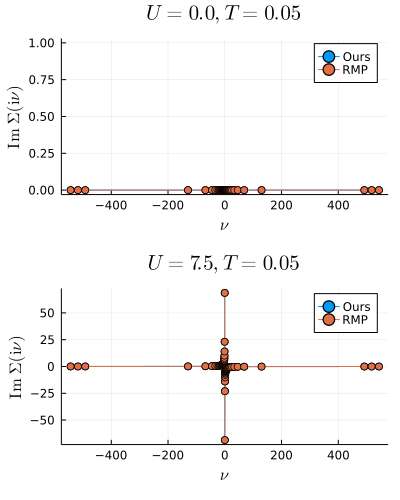

In [ ]:
sigma = imag.(sigma_history[begin][1])
sigma_rmp = imag.(sigma_history_rmp[begin][1])
v = sigma_history[begin][2]*pi/beta
p1 = plot(xlabel="\$\\nu\$", ylabel = "\$\\mathrm{Im}\\ \\Sigma(\\mathrm{i}\\nu)\$",
        title=latexstring("U=$(U_range[begin]),T=0.05"), size=(400,500))
plot!(v, sigma,     marker=:circle, label="Ours")
plot!(v, sigma_rmp, marker=:circle, label="RMP")

sigma = imag.(sigma_history[end][1])
sigma_rmp = imag.(sigma_history_rmp[end][1])
v = sigma_history[end][2]*pi/beta
p2 = plot(xlabel="\$\\nu\$", ylabel = "\$\\mathrm{Im}\\ \\Sigma(\\mathrm{i}\\nu)\$",
        title=latexstring("U=$(U_range[end]),T=0.05"), size=(400,500))
plot!(v, sigma,     marker=:circle, label="Ours")
plot!(v, sigma_rmp, marker=:circle, label="RMP")

plot(p1,p2,layout=(2,1))

### Visualization

In [ ]:
#=
sigma = imag.(sigma_history[begin][1])
v = sigma_history[begin][2]*pi/beta
p1 = plot(xlabel="\$\\nu\$", ylabel = "\$\\mathrm{Im}\\ \\Sigma(\\mathrm{i}\\nu)\$",
        title=latexstring("U=$(U_range[begin]),T=0.05"), size=(400,500))
plot!(v, sigma, marker=:circle, label=nothing)

sigma = imag.(sigma_history[end][1])
v = sigma_history[end][2]*pi/beta
p2 = plot(xlabel="\$\\nu\$", ylabel = "\$\\mathrm{Im}\\ \\Sigma(\\mathrm{i}\\nu)\$",
        title=latexstring("U=$(U_range[end]),T=0.05"), size=(400,500))
plot!(v, sigma, marker=:circle, label=nothing)

plot(p1,p2,layout=(2,1))
=#

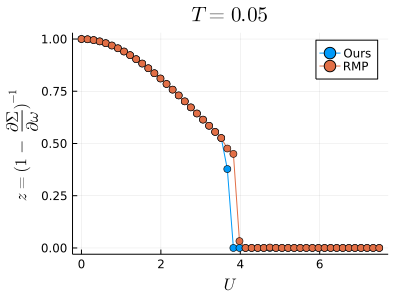

In [ ]:
p = plot(xlabel="\$U\$", ylabel = "\$z=(1-\\frac{\\partial \\Sigma}{\\partial \\omega})^{-1}\$",
        title=latexstring("T=0.05"), size=(400,300))
plot!(U_range, Z,     marker=:circle, label="Ours")
plot!(U_range, Z_rmp, marker=:circle, label="RMP")


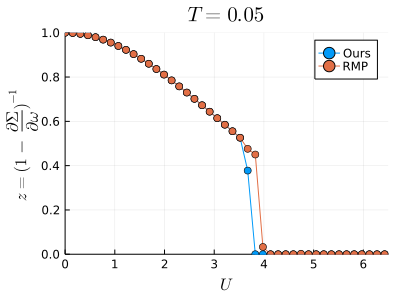

In [ ]:
p = plot(xlabel="\$U\$", ylabel = "\$z=(1-\\frac{\\partial \\Sigma}{\\partial \\omega})^{-1}\$",
        title=latexstring("T=0.05"), size=(400,300),xrange=(0.0,6.5),yrange=(0,1.0))
plot!(U_range, Z,     marker=:circle, label="Ours")
plot!(U_range, Z_rmp, marker=:circle, label="RMP")
